# Kinetic Theory: Evolution from Non-Equilibrium
In this Julia Notebook, we set up a Kinetic Theory problem with an initial non-equilibrium state and evolve it according to the Boltzmann Equation using a Direct Monte-Carlo (DMC) method. The basic structure of this  will be as follows: We will start by setting up the initial state of our system of $N = 1024$ particles and assigning them velocities from a non-equilibrium distribution function. Then, we will start considering the temporal evolution of our system by simulating pairwise collisions. Finally, we will also need to measure some properties (namely, $\langle v^2\rangle$, $\langle v^4\rangle$ and $H$)

In [526]:
using LinearAlgebra
using Plots
using Statistics
using StatsBase
N = 60000 # Number of particles
vt = 2.5 #Thermal velocity
T = pi*vt^2/8 #Temperature
a = √(T)
MaxwellBoltzmann(v,a=a) = sqrt(2/π)*v^2/a^3*exp(-v^2/(2a^2)) #Maxwell-Boltzmann distribution
v = zeros(N,3) #Velocities, unnitialized 
#Now, we start to sample the velocities. For this, we will set them to have constant speed and random directions
function SphereSample(r)
    ϕ = 2π*rand() #ϕ = U(0,2π)
    θ = acos(2*rand()-1) #cosθ = U(-1,1)
    vx = r*sin(θ)*cos(ϕ) #Velocity x
    vy = r*sin(θ)*sin(ϕ) #Velocity y
    vz = r*cos(θ) #Velocity z
    return [vx, vy, vz]
end
for i in 1:N
    v[i,1],v[i,2],v[i,3] = SphereSample(vt)
end
#plot velocities with equal aspect ratio
function AverageVel(v)
    return [mean(v[:,1]),mean(v[:,2]),mean(v[:,3])]
end
ConserveMom(v) = transpose(transpose(v) .- AverageVel(v))
#Finally, we subtract the average velocity from the velocities
v = ConserveMom(v)
scatter(v[:,1],v[:,2],label="Velocities",xlabel="x",ylabel="y",title="Velocities",aspect_ratio=:equal)
#Average velocity in module
function AbsoluteVelocity(v)
    return sqrt.(v[:,1].^2 + v[:,2].^2 + v[:,3].^2)
end

AbsoluteVelocity (generic function with 1 method)

┌ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\BoltzmannNoneq\Velocities.gif
└ @ Plots C:\Users\batti\.julia\packages\Plots\rz1WP\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\BoltzmannNoneq\\Velocities.gif")
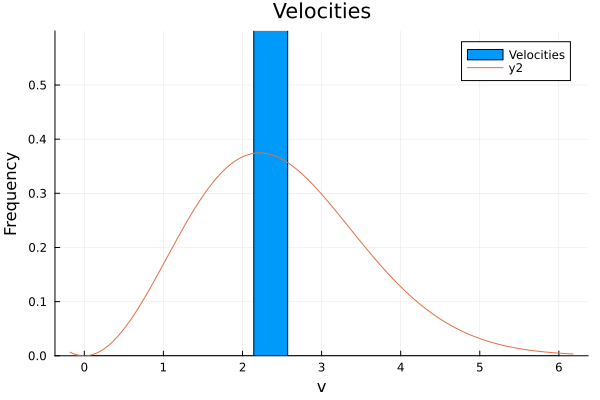

In [527]:
#We start calulating the effects of collisions by DMC
#We will use a simple model of elastic collisions, where the velocities are just exchanged
function Evolve(v,steps=1)
    for i in 1:steps*N
        p1 = rand(1:N) #Random particle 1
        p2 = rand(1:N) #Random particle 2
        σ = SphereSample(1.0) #Random direction
        vrel = v[p1,:] - v[p2,:] #Relative velocity
        v[p1,:] = v[p1,:] - (vrel⋅σ)*σ #Update velocity 1
        v[p2,:] = v[p2,:] + (vrel⋅σ)*σ #Update velocity 2
    end
    return v
end
function EntropyCalc(vmod,bins=15)
    Hist = fit(Histogram,vmod,range(0,6,bins)).weights/N
    Entropy = 0
    for i=1:bins-1
        if Hist[i] != 0
            Entropy = Hist[i]*log(Hist[i])
        else 
            Entropy = 0
        end
    end
    return Entropy
end
v² = []
v⁴ = []
v⁶=[]
H = []
#Make a gif of the evolution of the histograms of the absolute values of the velocities
anim = @animate for i in 1:100
    vmod = AbsoluteVelocity(v)
    #Calculating the normalized histogram vector
    push!(v²,mean(vmod.^2))
    push!(v⁴,mean(vmod.^4))
    push!(v⁶,mean(vmod.^6))
    push!(H,EntropyCalc(vmod,10))
    histogram(vmod,label="Velocities",xlabel="v",ylabel="Frequency",title="Velocities",nbins=range(0,6,15),normalize=:pdf,ylims=(0,0.6))
    plot!(v->MaxwellBoltzmann(v,sqrt(pi*mean(vmod)^2/8)))
    Evolve(v)
end
gif(anim, "Velocities.gif", fps = 2)

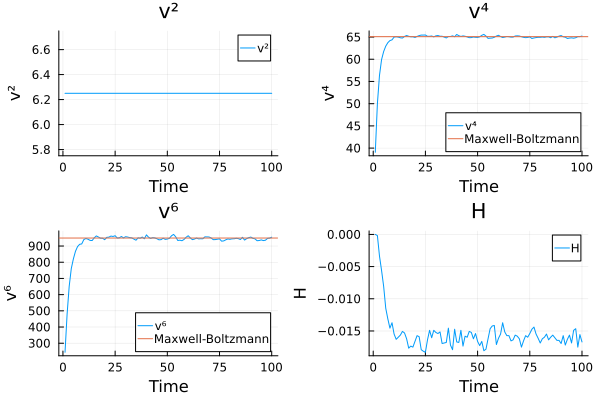

In [528]:
p1 = plot(v²,label="v²",xlabel="Time",ylabel="v²",title="v²",yrange=(mean(v²)-0.5,mean(v²)+0.5))
p2 = plot(v⁴,label="v⁴",xlabel="Time",ylabel="v⁴",title="v⁴")
hline!([quadgk(v->v^4*MaxwellBoltzmann(v,sqrt(pi*mean(vmod)^2/8)),0,Inf)[1]],label="Maxwell-Boltzmann")
p3 = plot(v⁶,label="v⁶",xlabel="Time",ylabel="v⁶",title="v⁶")
hline!([quadgk(v->v^6*MaxwellBoltzmann(v,sqrt(pi*mean(vmod)^2/8)),0,Inf)[1]],label="Maxwell-Boltzmann")
p4 = plot(H,label="H",xlabel="Time",ylabel="H",title="H")
plot(p1,p2,p3,p4)